In [1]:
from app import app
import pandas as pd
import datetime as dt 
import numpy as np
import json

from sqlalchemy import create_engine

from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras.models import Sequential 
from keras.layers import Dense, LSTM, Dropout

from flask import Flask, jsonify, request, make_response
from flask import flash, request

from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
sns.set_theme(style="darkgrid")

In [2]:
raw_data_set=pd.DataFrame()
data_set =pd.DataFrame()
index_data_set =pd.DataFrame()
tranning_set=pd.DataFrame()
result=pd.DataFrame()

In [3]:
def read_data_set():
  # Declare global variable 
  global data_set
  global raw_data_set
  global index_data_set

  # Define database connection 
  db_connection_str = 'mysql+pymysql://root:@localhost/csct'
  db_connection = create_engine(db_connection_str)

  # Read data in to Data Frame 
  raw_data_set = pd.read_sql('SELECT * FROM aw_product_demand', con=db_connection)


  # Validate Date
  raw_data_set['Date']= pd.to_datetime(raw_data_set['Date']).dt.date
  raw_data_set['Order_Demand'] = raw_data_set['Order_Demand'].astype('int64')

  #combine to single date
  data_set = raw_data_set.groupby('Date')['Order_Demand'].sum().reset_index()
  
  data_set.sort_values('Date', inplace=True)
  data_set['Date']=data_set['Date'].astype(str)

  # Create index data frame 
  index_data_set=data_set

  index_data_set=index_data_set.set_index(index_data_set['Date'])

  return data_set

In [4]:
read_data_set()

,Date,Order_Demand
0,2019-01-02,5274
1,2019-01-03,5128
2,2019-01-04,5391
3,2019-01-07,5380
4,2019-01-08,5427
...,...,...
995,2022-12-13,9563
996,2022-12-14,9507
997,2022-12-15,9087
998,2022-12-16,9027


In [5]:
FullData=data_set[['Order_Demand']].values
print(FullData[0:5])

[[5274]
 [5128]
 [5391]
 [5380]
 [5427]]


In [6]:
# Feature Scaling for fast training of neural networks
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Choosing between Standardization or normalization
# sc = StandardScaler()
sc=MinMaxScaler()

DataScaler = sc.fit(FullData)
X=DataScaler.transform(FullData)
#X=FullData

print('### After Normalization ###')
X[0:5]

### After Normalization ###


array([[0.01481331],
       [0.        ],
       [0.02668425],
       [0.02556818],
       [0.03033685]])

In [7]:
# split into samples
X_samples = list()
y_samples = list()

NumerOfRows = len(X)
TimeSteps=10  # next day's Price Prediction is based on last how many past day's prices

# Iterate thru the values to create combinations
for i in range(TimeSteps , NumerOfRows , 1):
    x_sample = X[i-TimeSteps:i]
    y_sample = X[i]
    X_samples.append(x_sample)
    y_samples.append(y_sample)

################################################
# Reshape the Input as a 3D (number of samples, Time Steps, Features)
X_data=np.array(X_samples)
X_data=X_data.reshape(X_data.shape[0],X_data.shape[1], 1)
print('\n#### Input Data shape ####')
print(X_data.shape)

# We do not reshape y as a 3D data  as it is supposed to be a single column only
y_data=np.array(y_samples)
y_data=y_data.reshape(y_data.shape[0], 1)
print('\n#### Output Data shape ####')
print(y_data.shape)


#### Input Data shape ####
(990, 10, 1)

#### Output Data shape ####
(990, 1)


In [8]:

# Choosing the number of testing data records
TestingRecords=5

# Splitting the data into train and test
X_train=X_data[:-TestingRecords]
X_test=X_data[-TestingRecords:]
y_train=y_data[:-TestingRecords]
y_test=y_data[-TestingRecords:]

############################################

# Printing the shape of training and testing
print('\n#### Training Data shape ####')
print(X_train.shape)
print(y_train.shape)
print('\n#### Testing Data shape ####')
print(X_test.shape)
print(y_test.shape)
# Choosing the number of testing data records
TestingRecords=5
 
# Splitting the data into train and test
X_train=X_data[:-TestingRecords]
X_test=X_data[-TestingRecords:]
y_train=y_data[:-TestingRecords]
y_test=y_data[-TestingRecords:]
 
############################################
 
# Printing the shape of training and testing
print('\n#### Training Data shape ####')
print(X_train.shape)
print(y_train.shape)
print('\n#### Testing Data shape ####')
print(X_test.shape)
print(y_test.shape)


#### Training Data shape ####
(985, 10, 1)
(985, 1)

#### Testing Data shape ####
(5, 10, 1)
(5, 1)

#### Training Data shape ####
(985, 10, 1)
(985, 1)

#### Testing Data shape ####
(5, 10, 1)
(5, 1)


In [9]:
# Visualizing the input and output being sent to the LSTM model
for inp, out in zip(X_train[0:2], y_train[0:2]):
    print(inp,'--', out)

[[0.01481331]
 [0.        ]
 [0.02668425]
 [0.02556818]
 [0.03033685]
 [0.02851055]
 [0.0270901 ]
 [0.0197849 ]
 [0.01318994]
 [0.03094562]] -- [0.03246753]
[[0.        ]
 [0.02668425]
 [0.02556818]
 [0.03033685]
 [0.02851055]
 [0.0270901 ]
 [0.0197849 ]
 [0.01318994]
 [0.03094562]
 [0.03246753]] -- [0.03733766]


In [10]:

# Defining Input shapes for LSTM
TimeSteps=X_train.shape[1]
TotalFeatures=X_train.shape[2]
print("Number of TimeSteps:", TimeSteps)
print("Number of Features:", TotalFeatures)

# Defining Input shapes for LSTM
TimeSteps=X_train.shape[1]
TotalFeatures=X_train.shape[2]
print("Number of TimeSteps:", TimeSteps)
print("Number of Features:", TotalFeatures)

Number of TimeSteps: 10
Number of Features: 1
Number of TimeSteps: 10
Number of Features: 1


In [11]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# Initialising the RNN
regressor = Sequential()

# Adding the First input hidden layer and the LSTM layer
# return_sequences = True, means the output of every time step to be shared with hidden next layer
regressor.add(LSTM(units = 10, activation = 'relu', input_shape = (TimeSteps, TotalFeatures), return_sequences=True))

# Adding the Second Second hidden layer and the LSTM layer
regressor.add(LSTM(units = 5, activation = 'relu', input_shape = (TimeSteps, TotalFeatures), return_sequences=True))

# Adding the Second Third hidden layer and the LSTM layer
regressor.add(LSTM(units = 5, activation = 'relu', return_sequences=False ))


# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

##################################################

import time
# Measuring the time taken by the model to train
StartTime=time.time()

# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, batch_size = 5, epochs = 100)

EndTime=time.time()
print("## Total Time Taken: ", round((EndTime-StartTime)/60), 'Minutes ##')

Epoch 1/100
197/197 [==============================] - 4s 7ms/step - loss: 0.0846
Epoch 2/100
197/197 [==============================] - 2s 8ms/step - loss: 0.0035
Epoch 3/100
197/197 [==============================] - 2s 8ms/step - loss: 0.0023
Epoch 4/100
197/197 [==============================] - 2s 8ms/step - loss: 0.0021
Epoch 5/100
197/197 [==============================] - 1s 7ms/step - loss: 0.0020
Epoch 6/100
197/197 [==============================] - 2s 11ms/step - loss: 0.0018
Epoch 7/100
197/197 [==============================] - 2s 10ms/step - loss: 0.0019
Epoch 8/100
197/197 [==============================] - 2s 10ms/step - loss: 0.0018
Epoch 9/100
197/197 [==============================] - 2s 11ms/step - loss: 0.0017
Epoch 10/100
197/197 [==============================] - 2s 8ms/step - loss: 0.0018
Epoch 11/100
197/197 [==============================] - 2s 8ms/step - loss: 0.0017
Epoch 12/100
197/197 [==============================] - 2s 8ms/step - loss: 0.0016
Epoch 13/

1/1 [==============================] - 0s 494ms/step
Accuracy: 97.51038293839224


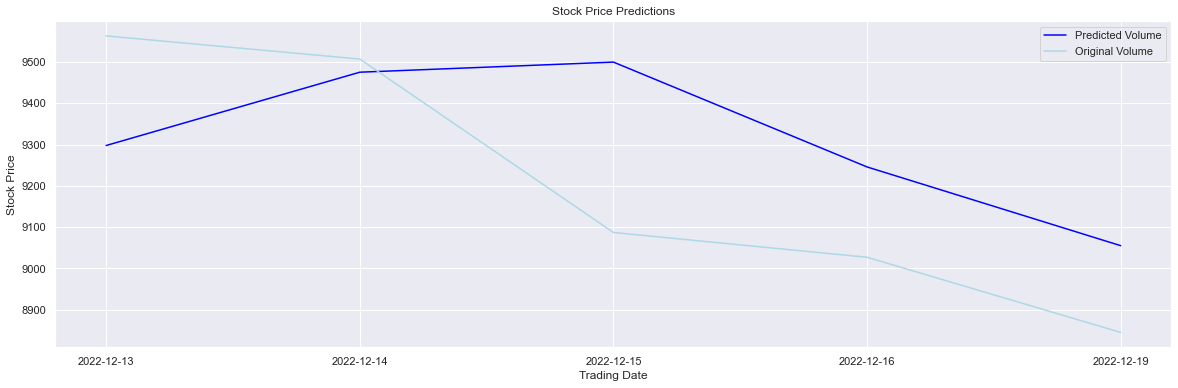

In [12]:
# Making predictions on test data
predicted_Price = regressor.predict(X_test)
predicted_Price = DataScaler.inverse_transform(predicted_Price)

# Getting the original price values for testing data
orig=y_test
orig=DataScaler.inverse_transform(y_test)

# Accuracy of the predictions
print('Accuracy:', 100 - (100*(abs(orig-predicted_Price)/orig)).mean())

# Visualising the results
import matplotlib.pyplot as plt

plt.plot(predicted_Price, color = 'blue', label = 'Predicted Volume')
plt.plot(orig, color = 'lightblue', label = 'Original Volume')

plt.title('Stock Price Predictions')
plt.xlabel('Trading Date')
plt.xticks(range(TestingRecords), data_set.tail(TestingRecords)['Date'])
plt.ylabel('Stock Price')

plt.legend()
fig=plt.gcf()
fig.set_figwidth(20)
fig.set_figheight(6)
plt.show()

1/1 [==============================] - 0s 28ms/step


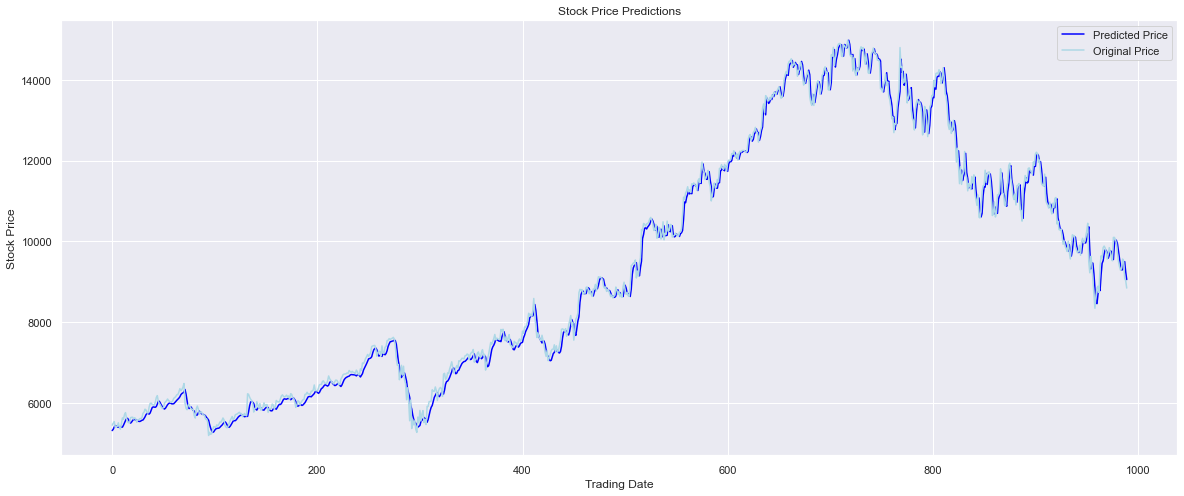

           Date  Order_Demand
990  2022-12-06          9699
991  2022-12-07          9495
992  2022-12-08          9371
993  2022-12-09          9284
994  2022-12-12          9331
995  2022-12-13          9563
996  2022-12-14          9507
997  2022-12-15          9087
998  2022-12-16          9027
999  2022-12-19          8845


In [13]:
# Generating predictions on full data
TrainPredictions=DataScaler.inverse_transform(regressor.predict(X_train))
TestPredictions=DataScaler.inverse_transform(regressor.predict(X_test))

FullDataPredictions=np.append(TrainPredictions, TestPredictions)
FullDataOrig=FullData[TimeSteps:]

# plotting the full data
plt.plot(FullDataPredictions, color = 'blue', label = 'Predicted Price')
plt.plot(FullDataOrig , color = 'lightblue', label = 'Original Price')


plt.title('Stock Price Predictions')
plt.xlabel('Trading Date')
plt.ylabel('Stock Price')
plt.legend()
fig=plt.gcf()
fig.set_figwidth(20)
fig.set_figheight(8)
plt.show()

print(data_set.tail(10))

In [14]:

# Last 10 days prices
Last10Days=np.array([9699, 9495, 9371, 9284, 9331,
            9563, 9507, 9087,9027, 8845])

# Normalizing the data just like we did for training the model
Last10Days=DataScaler.transform(Last10Days.reshape(-1,1))

# Changing the shape of the data to 3D
# Choosing TimeSteps as 10 because we have used the same for training
NumSamples=1
TimeSteps=10
NumFeatures=1
Last10Days=Last10Days.reshape(NumSamples,TimeSteps,NumFeatures)

#############################

# Making predictions on data
predicted_Price = regressor.predict(Last10Days)
predicted_Price = DataScaler.inverse_transform(predicted_Price)
predicted_Price


1/1 [==============================] - 0s 35ms/step


array([[8893.092]], dtype=float32)

In [15]:
from datetime import datetime
now = datetime.now()
current_time=now.strftime("%d/%m/%Y %H:%M:%S")

print(current_time)


10/01/2023 04:46:57


In [29]:
index_data_set=data_set

index_data_set=index_data_set.set_index(index_data_set['Date'])
index_data_set = index_data_set.drop('Date', axis=1)
index_data_set.to_csv('data.csv')





Date
2019-01-02    5274.467346
2019-01-03    5286.437851
2019-01-04    5298.408355
2019-01-07    5310.378859
2019-01-08    5322.349363
                 ...     
2022-12-13    9372.683704
2022-12-14    9365.956674
2022-12-15    9359.229644
2022-12-16    9352.502614
2022-12-19    9345.775584
Name: trend, Length: 1000, dtype: float64
Date
2019-01-02    1.005683
2019-01-03    1.005034
2019-01-04    0.995912
2019-01-07    0.999527
2019-01-08    0.999127
                ...   
2022-12-13    0.999660
2022-12-14    1.001736
2022-12-15    1.000384
2022-12-16    0.996510
2022-12-19    0.992585
Name: seasonal, Length: 1000, dtype: float64
Date
2019-01-02    0.994261
2019-01-03    0.965170
2019-01-04    1.021652
2019-01-07    1.013590
2019-01-08    1.020554
                ...   
2022-12-13    1.020652
2022-12-14    1.013300
2022-12-15    0.970540
2022-12-16    0.968577
2022-12-19    0.953487
Name: resid, Length: 1000, dtype: float64
Date
2019-01-02    5274.0
2019-01-03    5128.0
2019-01-04    539

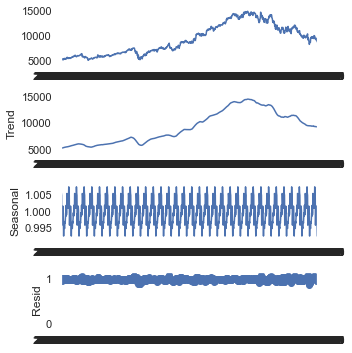

In [43]:

from pandas import read_csv
from matplotlib import pyplot
from statsmodels.tsa.seasonal import seasonal_decompose
series = read_csv('airline-passengers.csv', header=0, index_col=0)
series

result = seasonal_decompose(index_data_set, model='multiplicative',extrapolate_trend='freq', period=30)
print("___Trend__")
print(result.trend)
print(result.seasonal)
print(result.resid)
print(result.observed)
result.plot()
pyplot.show()

In [45]:
print(result.trend)
print(result.seasonal)
print(result.resid)
print(result.observed)

Date
2019-01-02    5274.0
2019-01-03    5128.0
2019-01-04    5391.0
2019-01-07    5380.0
2019-01-08    5427.0
               ...  
2022-12-13    9563.0
2022-12-14    9507.0
2022-12-15    9087.0
2022-12-16    9027.0
2022-12-19    8845.0
Length: 1000, dtype: float64


In [38]:
df_test = pd.DataFrame({'timestamp': [1462352000000000000, 1462352100000000000, 1462352200000000000, 1462352300000000000],
                'listData': [[1,2,1,9], [2,2,3,0], [1,3,3,0], [1,1,3,9]],
                'duration_sec': [3.0, 3.0, 3.0, 3.0]})
tdi = pd.DatetimeIndex(df_test.timestamp)
df_test.set_index(tdi, inplace=True)
df_test.drop(columns='timestamp', inplace=True)
df_test.index.name = 'datetimeindex'

df_test = df_test.explode('listData') 
sizes = df_test.groupby(level=0)['listData'].transform('size').sub(1)
duration = df_test['duration_sec'].div(sizes)
df_test.index += pd.to_timedelta(df_test.groupby(level=0).cumcount() * duration, unit='s') 

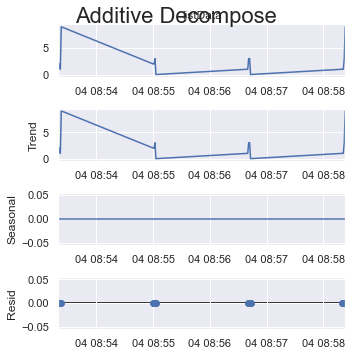

In [39]:
result_add = seasonal_decompose(x=df_test['listData'], model='additive', extrapolate_trend='freq', period=1)
plt.rcParams.update({'figure.figsize': (5,5)})
result_add.plot().suptitle('Additive Decompose', fontsize=22)
plt.show()